In [95]:
'''Import all necessary packages...pandas for data munging, 
sklearn's data preprocessing module, seaborn for data visualization
%matplotlib for making any plots show up inside of this notebook.
joblib for saving models (serialize/deserialize module). We will discuss
each of these packages as we use them for our analysis'''


import pandas as pd
from pandas.api.types import is_string_dtype,is_numeric_dtype
from sklearn import preprocessing
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix,accuracy_score,matthews_corrcoef,f1_score
from sklearn.externals import joblib
from matplotlib import pyplot as plt
import seaborn as sns
import joblib

%matplotlib inline

In [96]:
from sklearn.impute import KNNImputer

In [97]:
#Check the path to the directory where you are currently in
%pwd

'D:\\Information system\\Sem 1\\Info 6105\\Assignment 2'

In [98]:
'''Define a variable that points to this. This will let you avoid typing
the long path everytime you need to use it'''

my_path = 'D:\\Information system\\Sem 1\\Info 6105'

In [99]:
# II. Reading data into the notebook

In [100]:
'''We will use the Titanic dataset, as supplied here (Titanic_full.csv).
The same dataset can be downloaded from the Kaggle website. Check the
shape and header of the data you just read in as a dataframe. The use of
f and {} is specific to the recent versions of Python (3.x). You can as 
well type the full path here, and that works too!'''

my_df = pd.read_csv(f'{my_path}/Titanic_full.csv')
print(my_df.shape)
my_df.head(3)

(1309, 12)


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S


In [101]:
# III. Train - Valid- Test Split

In [102]:
'''As we have seen, it's important to avoid the Texas sharp shooter logical
fallacy. So, we plit the data into three sets in a 70-15-15 manner. 
This means 70% of the data rows go into building or training the model. 
This 70% is often called a training set. 15% of the data goes into 
evaluating model performance as you manually change or set the model 
hyperparameters (e.g. Value of K is a hyperparameter,in K-NN algorithm). 
This dataset is sometimes called a holdout set or the validation set. 
Finally, the last 15% of the data is the test set.  This dataset is 
never "seen" by the model for model building or hyperparamter tuning. After
hyperparameter tuning and model selection, which we will discuss later,
the model's final performance before sneidng it to production, will be
evalauted on this test data set.
The way the datarows are distributed will depend on the type of problem. 
Here, assuming the datarows of my_df are randomly arranged, and there's
no time component, we will simply simply do the split, using a split 
function that we define. Also, this 15% split 
for the test set may change, if the actual test set size is predefined. 
In any case we will make sure the test set we choose from our dataset 
is as similar as it can get to the actual data that it will see in 
production'''

#Calculate 15% of 1309. This is about 209 rows of data. 
#So, 1309 - 209 = 1100 rows of data will remain for the
#train and valid sets which we will separate later. 200 rows of data will
#go as test set data

def mydf_splitter(my_df,num_rows):
    return my_df[:num_rows].copy(),my_df[num_rows:]


mydf_train_valid,mydf_test = mydf_splitter(my_df,1100)

print(mydf_train_valid.shape,mydf_test.shape)

#We are going to put away the mydf_test for now. 
#We will return to it later.

(1100, 12) (209, 12)


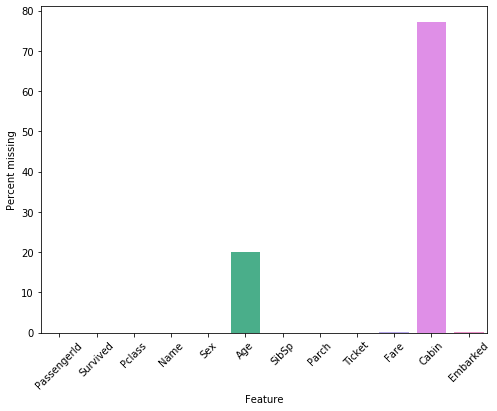

In [103]:
''' Deal with missing values. First, calculate the percentage of
missing values for every column, and plot them as a bar chart'''

null_vals = mydf_train_valid.isnull().sum()/len(mydf_train_valid)*100
null_vals = pd.DataFrame(null_vals)
null_vals.reset_index(inplace = True)
null_vals.columns = ["Feature","Percent missing"]
plt.figure(figsize = (8,6))
plt.xticks(rotation=45)
sns.barplot(x = "Feature",y ="Percent missing",data = null_vals)

In [104]:
mydf_train_valid_2 = mydf_train_valid.drop("Cabin",axis = 1)
print(mydf_train_valid_2.shape)
mydf_train_valid_2.head(15)

(1100, 11)


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,S
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,Q
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,S
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,S
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,S
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,237736,30.0708,C


In [105]:
#Check types of each column with the dataframe info () method
mydf_train_valid_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1100 entries, 0 to 1099
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  1100 non-null   int64  
 1   Survived     1100 non-null   int64  
 2   Pclass       1100 non-null   int64  
 3   Name         1100 non-null   object 
 4   Sex          1100 non-null   object 
 5   Age          881 non-null    float64
 6   SibSp        1100 non-null   int64  
 7   Parch        1100 non-null   int64  
 8   Ticket       1100 non-null   object 
 9   Fare         1099 non-null   float64
 10  Embarked     1098 non-null   object 
dtypes: float64(2), int64(5), object(4)
memory usage: 94.7+ KB


In [106]:
#Check the Dataset for Null Values
mydf_train_valid_2.isnull().any()

PassengerId    False
Survived       False
Pclass         False
Name           False
Sex            False
Age             True
SibSp          False
Parch          False
Ticket         False
Fare            True
Embarked        True
dtype: bool

In [107]:
mydf_train_valid_2.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            219
SibSp            0
Parch            0
Ticket           0
Fare             1
Embarked         2
dtype: int64

In [108]:
#Convert Object values to Categorical Values
cat_variables = mydf_train_valid_2[["Sex", "Embarked"]]
cat_dummies = pd.get_dummies(cat_variables, drop_first=True)
cat_dummies.head()

,Sex_male,Embarked_Q,Embarked_S
0,1,0,1
1,0,0,0
2,0,0,1
3,0,0,1
4,1,0,1


# KNN Imputer

In [109]:
#Drop the coloumn with data type as Object
knn_imp = mydf_train_valid_2.drop(["Sex", "Embarked"], axis=1)
knn_imp = pd.concat([knn_imp, cat_dummies], axis=1)
knn_imp.head()

,PassengerId,Survived,Pclass,Name,Age,SibSp,Parch,Ticket,Fare,Sex_male,Embarked_Q,Embarked_S
0,1,0,3,"Braund, Mr. Owen Harris",22.0,1,0,A/5 21171,7.2500,1,0,1
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",38.0,1,0,PC 17599,71.2833,0,0,0
2,3,1,3,"Heikkinen, Miss. Laina",26.0,0,0,STON/O2. 3101282,7.9250,0,0,1
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",35.0,1,0,113803,53.1000,0,0,1
4,5,0,3,"Allen, Mr. William Henry",35.0,0,0,373450,8.0500,1,0,1


In [110]:
#Drop other coloumns with Objecty Type
knn_imp = knn_imp.drop(['PassengerId', 'Name', 
              'Ticket'], axis=1)

In [111]:
#All the DataTypes are converted to Number Types
knn_imp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1100 entries, 0 to 1099
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Survived    1100 non-null   int64  
 1   Pclass      1100 non-null   int64  
 2   Age         881 non-null    float64
 3   SibSp       1100 non-null   int64  
 4   Parch       1100 non-null   int64  
 5   Fare        1099 non-null   float64
 6   Sex_male    1100 non-null   uint8  
 7   Embarked_Q  1100 non-null   uint8  
 8   Embarked_S  1100 non-null   uint8  
dtypes: float64(2), int64(4), uint8(3)
memory usage: 54.9 KB


In [112]:
#Scaling the Dataset
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
knn_imp = pd.DataFrame(scaler.fit_transform(knn_imp), columns = knn_imp.columns)
knn_imp.head()

,Survived,Pclass,Age,SibSp,Parch,Fare,Sex_male,Embarked_Q,Embarked_S
0,0.0,1.0,0.271997,0.125,0.0,0.014151,1.0,0.0,1.0
1,1.0,0.0,0.472825,0.125,0.0,0.139136,0.0,0.0,0.0
2,1.0,1.0,0.322204,0.000,0.0,0.015469,0.0,0.0,1.0
3,1.0,0.0,0.435170,0.125,0.0,0.103644,0.0,0.0,1.0
4,0.0,1.0,0.435170,0.000,0.0,0.015713,1.0,0.0,1.0


In [113]:
#Implementing the KNN Imputer for the Dataset
imputer = KNNImputer(n_neighbors=5)
knn_imp = pd.DataFrame(imputer.fit_transform(knn_imp),columns = knn_imp.columns)

In [114]:
#There are no NULL values in any coloumns
knn_imp.isna().any()

Survived      False
Pclass        False
Age           False
SibSp         False
Parch         False
Fare          False
Sex_male      False
Embarked_Q    False
Embarked_S    False
dtype: bool

In [115]:
knn_imp.isna().sum()

Survived      0
Pclass        0
Age           0
SibSp         0
Parch         0
Fare          0
Sex_male      0
Embarked_Q    0
Embarked_S    0
dtype: int64

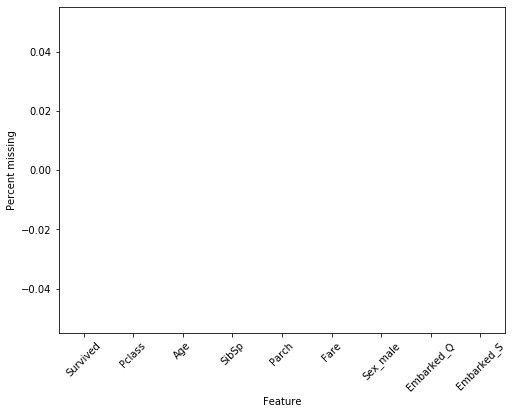

In [116]:
#Check to see if any missing values are present
null_vals = knn_imp.isnull().sum()/len(knn_imp)*100
null_vals = pd.DataFrame(null_vals)
null_vals.reset_index(inplace = True)
null_vals.columns = ["Feature","Percent missing"]
plt.figure(figsize = (8,6))
plt.xticks(rotation=45)
sns.barplot(x = "Feature",y ="Percent missing",data = null_vals)

In [117]:
'''Now, let's separate the X and Y variables (vertical split of the 
dataframe). Here the Y column is the variable we are trying to predict, 
survived or not(0 = No, 1 = Yes)'''

Y = knn_imp["Survived"]
X = knn_imp.drop(["Survived"],axis = 1)

print(X.shape,Y.shape)

(1100, 8) (1100,)


In [118]:
'''Then, split into train and valid sets for model building 
and hyperparameter tuning, respectively !Remember, we need to 
split (horizontally the rows) X_full into train and validation sets.
We use the dataframe splitter function we defined previously.
Strictly for later use in another module, merge X and Y and store.
Save it as train data. Reason explained in module III'''

X_train,X_valid = mydf_splitter(X,900)
Y_train,Y_valid = mydf_splitter(Y,900)

print(X_train.shape,X_valid.shape,Y_train.shape,Y_valid.shape)


(900, 8) (200, 8) (900,) (200,)


In [119]:
'''Time for training the model and evaluating it on the validation set. 
At first, let's use the default values for the kNN hyperparameters -
n_neighbors = 3,weights = 'uniform'). KNN has more hyperparameters such as
leaf_size, metric, etc. But, these two are key hyperparamters'''

my_knn_model = KNeighborsClassifier(n_neighbors = 3,weights = 'uniform')
my_knn_model.fit(X_train,Y_train)

#Predict on the validation set
Y_pred = my_knn_model.predict(X_valid)

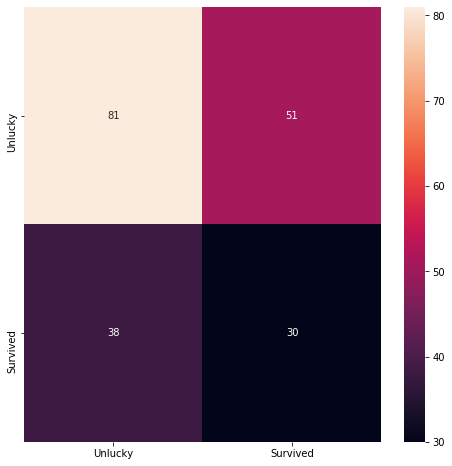

In [120]:
# Plot confusion matrix
from sklearn.metrics import confusion_matrix

my_knn_cmatrix = confusion_matrix(Y_valid,Y_pred)

my_knn_df = pd.DataFrame(my_knn_cmatrix)
plt.figure(figsize = (8,8))
sns.heatmap(my_knn_df, xticklabels = ["Unlucky","Survived"],
            yticklabels = ["Unlucky","Survived"],annot = True)

In [121]:
print(accuracy_score(Y_valid,Y_pred),
      matthews_corrcoef(Y_valid,Y_pred),f1_score(Y_valid,Y_pred))

#An MCC of -0.0474 looks bad !We need to do model tuning or 
#hyperparameter tuning to try to make it better

0.555 0.05289415586931476 0.40268456375838924


# MICE Imputer

In [122]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer as MICE

In [123]:
mice_imp = mydf_train_valid_2.drop(["Sex", "Embarked"], axis=1)
mice_imp = pd.concat([mice_imp, cat_dummies], axis=1)
mice_imp = mice_imp.drop(['PassengerId', 'Name', 
              'Ticket'], axis=1)
mice_imp.head()
mice_imp.isna().any()

Survived      False
Pclass        False
Age            True
SibSp         False
Parch         False
Fare           True
Sex_male      False
Embarked_Q    False
Embarked_S    False
dtype: bool

In [124]:
mice_imp = pd.DataFrame(MICE().fit_transform(mice_imp),columns = mice_imp.columns)
#imp.transform(mice_imp)
mice_imp.isna().any()

Survived      False
Pclass        False
Age           False
SibSp         False
Parch         False
Fare          False
Sex_male      False
Embarked_Q    False
Embarked_S    False
dtype: bool

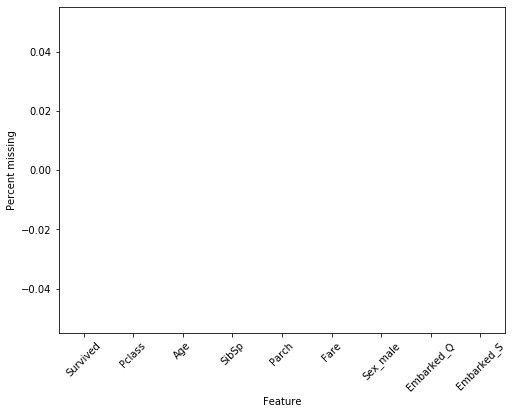

In [125]:
null_vals = mice_imp.isnull().sum()/len(mice_imp)*100
null_vals = pd.DataFrame(null_vals)
null_vals.reset_index(inplace = True)
null_vals.columns = ["Feature","Percent missing"]
plt.figure(figsize = (8,6))
plt.xticks(rotation=45)
sns.barplot(x = "Feature",y ="Percent missing",data = null_vals)

In [126]:
'''Now, let's separate the X and Y variables (vertical split of the 
dataframe). Here the Y column is the variable we are trying to predict, 
survived or not(0 = No, 1 = Yes)'''

Y_mice = mice_imp["Survived"]
X_mice = mice_imp.drop(["Survived"],axis = 1)

print(X_mice.shape,Y_mice.shape)

(1100, 8) (1100,)


In [127]:
'''Then, split into train and valid sets for model building 
and hyperparameter tuning, respectively !Remember, we need to 
split (horizontally the rows) X_full into train and validation sets.
We use the dataframe splitter function we defined previously.
Strictly for later use in another module, merge X and Y and store.
Save it as train data. Reason explained in module III'''

X_train_m,X_valid_m = mydf_splitter(X_mice,900)
Y_train_m,Y_valid_m = mydf_splitter(Y_mice,900)

print(X_train_m.shape,X_valid_m.shape,Y_train_m.shape,Y_valid_m.shape)

(900, 8) (200, 8) (900,) (200,)


In [128]:
'''Time for training the model and evaluating it on the validation set. 
At first, let's use the default values for the kNN hyperparameters -
n_neighbors = 3,weights = 'uniform'). KNN has more hyperparameters such as
leaf_size, metric, etc. But, these two are key hyperparamters'''

my_knn_model_mice = KNeighborsClassifier(n_neighbors = 3,weights = 'uniform')
my_knn_model_mice.fit(X_train_m,Y_train_m)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=3, p=2,
                     weights='uniform')

In [129]:
#Predict on the validation set
Y_pred_m = my_knn_model_mice.predict(X_valid_m)

0.61 0.1556983310350872 0.45833333333333337


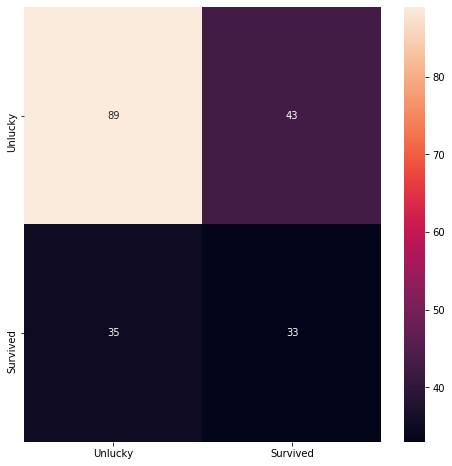

In [130]:
# Plot confusion matrix
from sklearn.metrics import confusion_matrix

my_knn_cmatrix_mice = confusion_matrix(Y_valid_m,Y_pred_m)

my_knn_df_m = pd.DataFrame(my_knn_cmatrix_mice)
plt.figure(figsize = (8,8))
sns.heatmap(my_knn_df_m, xticklabels = ["Unlucky","Survived"],
            yticklabels = ["Unlucky","Survived"],annot = True)

print(accuracy_score(Y_valid_m,Y_pred_m),
      matthews_corrcoef(Y_valid_m,Y_pred_m),f1_score(Y_valid_m,Y_pred_m))

# Simple Imputer 

In [131]:
from sklearn.impute import SimpleImputer

In [132]:
sim_imp = mydf_train_valid_2.drop(["Sex", "Embarked"], axis=1)
sim_imp = pd.concat([sim_imp, cat_dummies], axis=1)
sim_imp = sim_imp.drop(['PassengerId', 'Name', 
              'Ticket'], axis=1)
sim_imp.head()
sim_imp.isna().any()

Survived      False
Pclass        False
Age            True
SibSp         False
Parch         False
Fare           True
Sex_male      False
Embarked_Q    False
Embarked_S    False
dtype: bool

In [133]:
import numpy as np
imputer = SimpleImputer(missing_values=np.nan, strategy='median')
sim_imp = pd.DataFrame(imputer.fit_transform(sim_imp),columns = sim_imp.columns)
sim_imp.isna().any()
sim_imp.head()

,Survived,Pclass,Age,SibSp,Parch,Fare,Sex_male,Embarked_Q,Embarked_S
0,0.0,3.0,22.0,1.0,0.0,7.2500,1.0,0.0,1.0
1,1.0,1.0,38.0,1.0,0.0,71.2833,0.0,0.0,0.0
2,1.0,3.0,26.0,0.0,0.0,7.9250,0.0,0.0,1.0
3,1.0,1.0,35.0,1.0,0.0,53.1000,0.0,0.0,1.0
4,0.0,3.0,35.0,0.0,0.0,8.0500,1.0,0.0,1.0


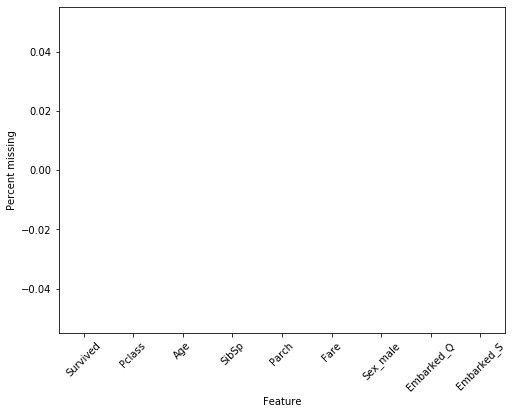

In [134]:
null_vals = sim_imp.isnull().sum()/len(sim_imp)*100
null_vals = pd.DataFrame(null_vals)
null_vals.reset_index(inplace = True)
null_vals.columns = ["Feature","Percent missing"]
plt.figure(figsize = (8,6))
plt.xticks(rotation=45)
sns.barplot(x = "Feature",y ="Percent missing",data = null_vals)

In [135]:
'''Now, let's separate the X and Y variables (vertical split of the 
dataframe). Here the Y column is the variable we are trying to predict, 
survived or not(0 = No, 1 = Yes)'''

Y_s = sim_imp["Survived"]
X_s = sim_imp.drop(["Survived"],axis = 1)

print(X.shape,Y.shape)

(1100, 8) (1100,)


In [136]:
'''Then, split into train and valid sets for model building 
and hyperparameter tuning, respectively !Remember, we need to 
split (horizontally the rows) X_full into train and validation sets.
We use the dataframe splitter function we defined previously.
Strictly for later use in another module, merge X and Y and store.
Save it as train data. Reason explained in module III'''

X_train_s,X_valid_s = mydf_splitter(X_s,900)
Y_train_s,Y_valid_s = mydf_splitter(Y_s,900)

print(X_train_s.shape,X_valid_s.shape,Y_train_s.shape,Y_valid_s.shape)


(900, 8) (200, 8) (900,) (200,)


In [137]:
'''Time for training the model and evaluating it on the validation set. 
At first, let's use the default values for the kNN hyperparameters -
n_neighbors = 3,weights = 'uniform'). KNN has more hyperparameters such as
leaf_size, metric, etc. But, these two are key hyperparamters'''

my_knn_model_s = KNeighborsClassifier(n_neighbors = 3,weights = 'uniform')
my_knn_model_s.fit(X_train_s,Y_train_s)

#Predict on the validation set
Y_pred_s = my_knn_model_s.predict(X_valid_s)

In [138]:
#Predict on the validation set
Y_pred_s = my_knn_model_s.predict(X_valid_s)

0.55 0.038781576749626435 0.39189189189189183


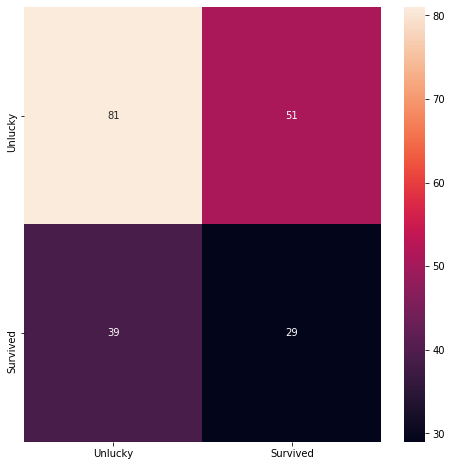

In [139]:
# Plot confusion matrix
from sklearn.metrics import confusion_matrix

my_knn_cmatrix_s = confusion_matrix(Y_valid_s,Y_pred_s)

my_knn_df_s = pd.DataFrame(my_knn_cmatrix_s)
plt.figure(figsize = (8,8))
sns.heatmap(my_knn_df_s, xticklabels = ["Unlucky","Survived"],
            yticklabels = ["Unlucky","Survived"],annot = True)

print(accuracy_score(Y_valid_s,Y_pred_s),
      matthews_corrcoef(Y_valid_s,Y_pred_s),f1_score(Y_valid_s,Y_pred_s))

The best imputation method can be identified using the Accuracy Score and the F1 score of the models. After applying the imputation method to the dataset the Imputed value was classified using the KNN classifier, the Accuracy and F1 score of each imputation method was considered to find the best one.

Accuracy and F1 scores:
KNN Imputer: 0.555, 0.40268456375838924
MICE Imputer: 0.61, 0.45833333333333337
Simple Imputer: 0.55, 0.39189189189189183
 
Based on the scores calculated MICE imputer might be the better Imputation Method.